
### 3. Option Market Layer

In this notebook you put a **simple European option layer** on top of your BTC price simulator.

You will:

- Define a **implied volatility (IV) surface** that reacts to maturity, moneyness, and local realised volatility.
- Use **Black–Scholes** with your IV surface to price calls/puts along simulated BTC paths.
- Inspect how IV and option prices behave in **calm vs. volatile** regimes.

(中文提示：这一层只是给后面 hedging 提供一个合理的 option 价格环境，不需要做很复杂的真实市场校准。)

---

#### 3.1 IV Setup and Local Volatility

We work with a European IV surface

$$
\sigma_{\text{IV}}(t, S_t, K, T)
= f\big(\tau,\ K/S_t,\ \hat{\sigma}_{\text{loc}}(t)\big),
\quad
\tau = T - t.
$$

Here:

- $\tau$: time to maturity.
- $K/S_t$: moneyness.
- $\hat{\sigma}_{\text{loc}}(t)$: **local realised volatility**, computed from your simulated BTC log-returns via a rolling window (e.g. last 1–4 hours of 5-minute returns, annualised).


**Minimal requirements**

- $\sigma_{\text{IV}}$ should depend on **maturity**:
  - Short-dated vs. longer-dated options can have different base vol levels.
- $\sigma_{\text{IV}}$ should depend on **moneyness**:
  - At least distinguish ATM vs. OTM (e.g. a tiny smile/skew).
- $\sigma_{\text{IV}}$ should react to **local realised volatility**:
  - Higher when $\hat{\sigma}_{\text{loc}}(t)$ is high (volatile regime),
  - Lower when $\hat{\sigma}_{\text{loc}}(t)$ is low (calm regime).


**Implementation tasks**

- Implement a rolling estimator for $\hat{\sigma}_{\text{loc}}(t)$ from your simulator paths.
- Choose a small number of parameters for $f(\cdot)$, and write down your formula clearly in the notebook.
- Implement the function  
 




In [3]:
import numpy as np
import pandas as pd
from scipy.stats import norm

# -----------------------
# Utilities
# -----------------------
def annualization_factor(delta_minutes):
    # periods per year for returns sampled every delta_minutes
    return np.sqrt((365*24*60) / delta_minutes)

# Black-Scholes (European call/put) - assumes zero dividends
def bs_price(S, K, tau, r, sigma, option_type='call'):
    """
    S, K, tau, r, sigma can be scalars or numpy arrays (broadcastable)
    tau in years; sigma in annual vol (decimal)
    returns price (same shape)
    """
    # handle tau == 0 -> option payoff
    S = np.asarray(S, dtype=float)
    K = np.asarray(K, dtype=float)
    tau = np.asarray(tau, dtype=float)
    sigma = np.asarray(sigma, dtype=float)
    r = float(r)

    price = np.zeros_like(S, dtype=float)

    # immediate expiry
    mask0 = (tau <= 0) | (sigma <= 1e-12)
    if np.any(mask0):
        if option_type == 'call':
            price[mask0] = np.maximum(S[mask0] - K[mask0], 0.0)
        else:
            price[mask0] = np.maximum(K[mask0] - S[mask0], 0.0)

    # normal case
    mask = ~mask0
    if np.any(mask):
        S_m = S[mask]; K_m = K[mask]; tau_m = tau[mask]; sigma_m = sigma[mask]
        sqrt_t = np.sqrt(tau_m)
        d1 = (np.log(S_m / K_m) + (r + 0.5 * sigma_m**2) * tau_m) / (sigma_m * sqrt_t)
        d2 = d1 - sigma_m * sqrt_t
        if option_type == 'call':
            price[mask] = S_m * norm.cdf(d1) - K_m * np.exp(-r * tau_m) * norm.cdf(d2)
        else:
            price[mask] = K_m * np.exp(-r * tau_m) * norm.cdf(-d2) - S_m * norm.cdf(-d1)
    return price

# -----------------------
# Rolling local realised vol
# -----------------------
def rolling_realised_vol(price_series, window_steps, delta_minutes, center=False):
    """
    price_series: pandas Series or 1D np.array of prices indexed by time order
    window_steps: number of past returns to use (e.g. 12 for 1 hour with 5-min bars)
    delta_minutes: sampling interval in minutes
    returns: pandas Series of annualized vol (aligned to original index), NaN for early times
    """
    if not isinstance(price_series, pd.Series):
        price_series = pd.Series(price_series)
    # log returns
    logr = np.log(price_series).diff()  # natural log returns per step
    var_rolling = logr.rolling(window=window_steps, center=center).var()  # sample var
    # convert per-step stdev to annualized vol
    ann_factor = annualization_factor(delta_minutes)
    realised_vol = np.sqrt(var_rolling) * ann_factor
    return realised_vol

# -----------------------
# IV surface function f(tau, m, local_vol)
# -----------------------
def iv_surface(tau_years, S, K, local_vol,
               sigma0=0.9, sigma_inf=0.55, kappa=6.0,
               A_sym=0.08, B=8.0, A_skew=0.06,
               alpha=0.9, sigma_ref=0.7):
    """
    tau_years: scalar or array of time-to-maturity in years
    S, K: underlying and strike (can be arrays - broadcasting rules)
    local_vol: local realised vol (annualized) at time t (scalar or array)
    returns: implied vol (annualized)
    """
    tau = np.maximum(tau_years, 0.0)
    # term structure
    term = sigma_inf + (sigma0 - sigma_inf) * np.exp(-kappa * tau)  # base vol depending on tau

    # moneyness
    m = np.asarray(K) / np.asarray(S)
    logm = np.log(m)
    smile = 1.0 + A_sym * (1.0 - np.exp(-B * np.abs(logm)))
    skew = 1.0 + A_skew * (-logm)   # if K < S -> logm<1 -> -logm>0 -> puts (low strikes) more expensive

    # local scale
    local_scale = 1.0 + alpha * (np.asarray(local_vol) / sigma_ref - 1.0)

    iv = term * smile * skew * local_scale
    # numeric floors
    iv = np.maximum(iv, 1e-4)
    return iv

# -----------------------
# Example: price options along one simulated path at time t
# -----------------------
def price_options_at_time(S_t, strikes, maturities_days, local_vol_t, r=0.0, delta_minutes=5):
    """
    S_t: scalar spot price at time t
    strikes: 1D array of strike prices
    maturities_days: 1D array (in days) of maturities T - t
    local_vol_t: scalar local realised vol (annualized)
    returns: dict of IVs and call/put prices (arrays with shape (len(maturities), len(strikes)))
    """
    strikes = np.asarray(strikes)
    maturities_days = np.asarray(maturities_days)
    tau_years = maturities_days / 365.0

    # build grid
    M, N = len(tau_years), len(strikes)
    tau_grid = np.repeat(tau_years[:, None], N, axis=1)
    K_grid = np.repeat(strikes[None, :], M, axis=0)
    S_grid = np.full_like(K_grid, fill_value=S_t, dtype=float)
    local_grid = np.full_like(K_grid, fill_value=local_vol_t, dtype=float)

    iv_grid = iv_surface(tau_grid, S_grid, K_grid, local_grid)
    call_grid = bs_price(S_grid, K_grid, tau_grid, r, iv_grid, option_type='call')
    put_grid = bs_price(S_grid, K_grid, tau_grid, r, iv_grid, option_type='put')
    return {'iv': iv_grid, 'call': call_grid, 'put': put_grid, 'tau': tau_grid, 'K': K_grid}

# -----------------------
# Demonstration: calm vs volatile
# -----------------------
if __name__ == "__main__":
    S_t = 30000.0
    strikes = np.array([0.8*S_t, 0.9*S_t, 1.0*S_t, 1.1*S_t, 1.2*S_t])
    maturities_days = np.array([1, 7, 30, 90])  # 1d, 1w, 1m, 3m

    local_calm = 0.4   # annualized 40%
    local_vol = 1.2    # annualized 120%

    res_calm = price_options_at_time(S_t, strikes, maturities_days, local_calm)
    res_vol = price_options_at_time(S_t, strikes, maturities_days, local_vol)

    print("IV (calm) matrix (rows=maturities, cols=strikes):\n", np.round(res_calm['iv'], 3))
    print("IV (volatile) matrix:\n", np.round(res_vol['iv'], 3))

    print("Call prices (calm):\n", np.round(res_calm['call'], 2))
    print("Call prices (volatile):\n", np.round(res_vol['call'], 2))


IV (calm) matrix (rows=maturities, cols=strikes):
 [[0.594 0.578 0.549 0.57  0.577]
 [0.572 0.557 0.529 0.549 0.556]
 [0.507 0.494 0.469 0.486 0.493]
 [0.418 0.407 0.387 0.401 0.406]]
IV (volatile) matrix:
 [[1.588 1.546 1.469 1.523 1.542]
 [1.531 1.49  1.416 1.468 1.487]
 [1.356 1.32  1.255 1.301 1.317]
 [1.118 1.089 1.035 1.073 1.086]]
Call prices (calm):
 [[6.00000e+03 3.00005e+03 3.44130e+02 1.80000e-01 0.00000e+00]
 [6.00154e+03 3.08676e+03 8.77390e+02 1.19990e+02 7.56000e+00]
 [6.10533e+03 3.53259e+03 1.60856e+03 6.43690e+02 2.14860e+02]
 [6.40031e+03 4.09746e+03 2.29538e+03 1.27798e+03 6.58410e+02]]
Call prices (volatile):
 [[6002.48 3104.31  920.15  141.96   10.96]
 [6426.59 4139.29 2343.28 1324.52  695.3 ]
 [7817.2  5940.32 4282.1  3308.89 2498.58]
 [9361.09 7683.65 6081.31 5217.5  4400.89]]



---

#### 3.2 Contract Universe

We work with a **fixed option grid**; you do not simulate listing / delisting of new strikes.

- Underlying: spot price $S_t$ from your BTC simulator.
- Reference spot for defining strikes: $S_0$ at the start of the simulation.
- Strikes:
  $$
  K \in \{0.9 S_0,\ S_0,\ 1.1 S_0\}.
  $$
- Maturities:
  $$
  T \in \{1\text{d},\ 7\text{d}\}.
  $$
- Time to maturity at time $t_n$:
  $$
  \tau_n(K, T) = \max(T - t_n,\ 0).
  $$

At each step:

- Existing positions are **marked to market** using your Black–Scholes prices.
- You may assume that positions can be **reduced or closed** at those prices.
- When $\tau_n = 0$, options are **settled to intrinsic value** and removed from the tradable universe.

**Implementation tasks**

- Create a data structure (e.g. a DataFrame or dictionary) that stores all contracts:
  - Keys: $(K, T, \text{type})$, where $\text{type} \in \{\text{call}, \text{put}\}$.
- At each time step $t_n$:
  - Update $\tau_n(K, T)$ for each contract.
  - Mark options with $\tau_n = 0$ as expired and settle them.
- Implement a simple **position book** that stores, for each contract:
  - Current quantity,
  - Current mark-to-market value.

(This will be reused later in the hedging environment.)

---



#### 3.3 Black–Scholes Pricing with IV

Given your IV surface, you price European options using Black–Scholes.

Let

$$
\sigma^\star = \sigma_{\text{IV}}(t, S_t, K, T).
$$

Then

$$
d_1
= \frac{\ln(S_t / K) + \tfrac{1}{2} (\sigma^\star)^2 \tau}
{\sigma^\star \sqrt{\tau}},
\qquad
d_2 = d_1 - \sigma^\star \sqrt{\tau},
$$

and call / put prices are

$$
C_t = S_t N(d_1) - K N(d_2),
\qquad
P_t = K N(-d_2) - S_t N(-d_1),
$$

where $N(\cdot)$ is the standard normal CDF.

(You may ignore interest rates and carry; this is a stylised setup.)

**Implementation tasks**

- Implement a function  
  `bs_price(S, K, tau, sigma, option_type)`  
  that returns $C_t$ or $P_t$ depending on `option_type`.
- Connect it to your IV surface:
  - For each contract $(K, T, \text{type})$ and time $t_n$:
    - Compute $\tau_n = \max(T - t_n, 0)$,
    - Compute $\hat{\sigma}_{\text{loc}}(t_n)$,
    - Compute $\sigma^\star = \sigma_{\text{IV}}(t_n, S_{t_n}, K, T)$,
    - Call `bs_price` to get the option price.
- Handle edge cases:
  - If $\tau$ is extremely small, approximate by intrinsic value.
  - Clip $\sigma^\star$ to a reasonable positive range to avoid numerical issues.



In [4]:
# 3.2-3.3 
import numpy as np
import pandas as pd

# -----------------------------------------------------
# 1. Create Contract Universe (fixed strikes/maturities)
# -----------------------------------------------------

def create_contract_universe(S0):
    strikes = [0.9 * S0, S0, 1.1 * S0]
    maturities = [1, 7]   # in days
    types = ["call", "put"]

    rows = []
    for K in strikes:
        for T in maturities:
            for opt_type in types:
                rows.append({
                    "strike": K,
                    "maturity_days": T,
                    "type": opt_type,
                    "tau": T / 365,          # initial tau
                    "price": 0.0,
                    "quantity": 0.0,
                    "mtm": 0.0,
                    "expired": False
                })
    return pd.DataFrame(rows)


In [5]:
from scipy.stats import norm

def bs_price(S, K, tau, sigma, option_type):
    """
    tau in years, sigma annualized
    Handles tau≈0 and sigma≈0 automatically.
    """
    if tau <= 1e-8 or sigma <= 1e-8:
        if option_type == "call":
            return max(S - K, 0)
        else:
            return max(K - S, 0)

    sqrt_tau = np.sqrt(tau)
    d1 = (np.log(S / K) + 0.5 * sigma * sigma * tau) / (sigma * sqrt_tau)
    d2 = d1 - sigma * sqrt_tau
    
    if option_type == "call":
        return S * norm.cdf(d1) - K * norm.cdf(d2)
    else:
        return K * norm.cdf(-d2) - S * norm.cdf(-d1)


In [6]:
def update_contracts(contract_df, t_days, S_t, local_vol_t):
    """
    contract_df: DataFrame with all contracts
    t_days: 当前模拟天数 (可为浮点数)
    S_t: 当前 BTC spot
    local_vol_t: rolling realised vol at time t (annualized)
    """
    for idx, row in contract_df.iterrows():

        if row["expired"]:
            continue  # skip expired contracts

        # --- 1. 更新 tau
        T_days = row["maturity_days"]
        tau = max((T_days - t_days) / 365.0, 0)
        contract_df.at[idx, "tau"] = tau

        # --- 2. 如果到期，按照 intrinsic 结算
        if tau <= 0:
            if row["type"] == "call":
                price = max(S_t - row["strike"], 0)
            else:
                price = max(row["strike"] - S_t, 0)

            contract_df.at[idx, "price"] = price
            contract_df.at[idx, "mtm"] = price * row["quantity"]
            contract_df.at[idx, "expired"] = True
            continue

        # --- 3. 未到期 → 使用 IV surface + Black-Scholes
        sigma_star = iv_surface(
            tau=row["tau"],
            S=S_t,
            K=row["strike"],
            local_vol=local_vol_t
        )

        # 数值稳定，避免 sigma = 0
        sigma_star = max(sigma_star, 1e-4)

        price = bs_price(
            S=S_t,
            K=row["strike"],
            tau=row["tau"],
            sigma=sigma_star,
            option_type=row["type"]
        )

        contract_df.at[idx, "price"] = price
        contract_df.at[idx, "mtm"] = price * row["quantity"]

    return contract_df



#### 3.4 Diagnostics and Plots

Before using this option layer for hedging, you should check that the IV and price behaviour is **qualitatively sensible**.

**Tasks**

- **Describe your IV design** :
  - How it depends on $\tau$,
  - How it depends on moneyness $K/S_t$,
  - How it reacts to $\hat{\sigma}_{\text{loc}}(t)$.
- Pick at least one **calm** and one **volatile** segment from a simulated path:
  - Use either $\hat{\sigma}_{\text{loc}}(t)$ or your regime labels from the price simulator.
- For a few selected times $t$:
  - Plot IV vs. moneyness for both maturities:
    - e.g. $K \in \{0.9 S_0,\ S_0,\ 1.1 S_0\}$, $T \in \{1\text{d}, 7\text{d}\}$.
  - Plot option prices vs. moneyness for the same grid.
- Comment briefly:
  - How IV levels change from calm to volatile regimes.
  - How call/put prices respond to changes in $S_t$ and $\hat{\sigma}_{\text{loc}}(t)$.
  - Whether the patterns look reasonable for later hedging experiments.

(中文提示：这里不用做很花哨的分析，目标只是「 sanity check 」——确认你设计的 IV surface 设计是比较贴合实际的。)

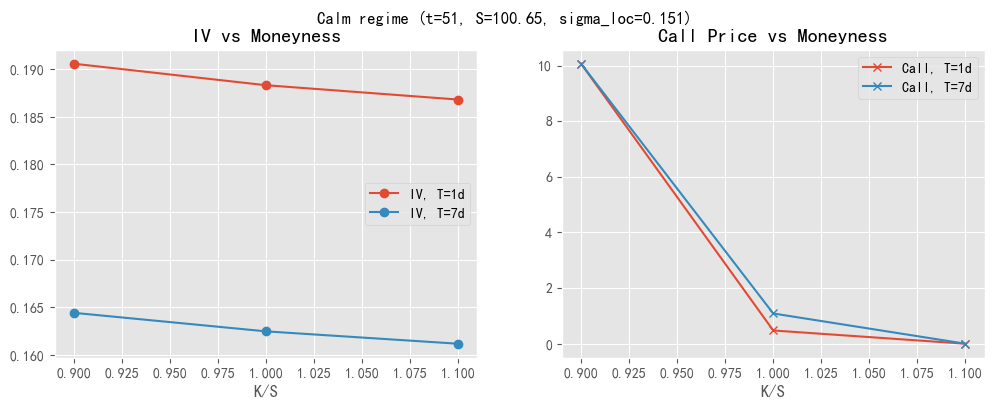

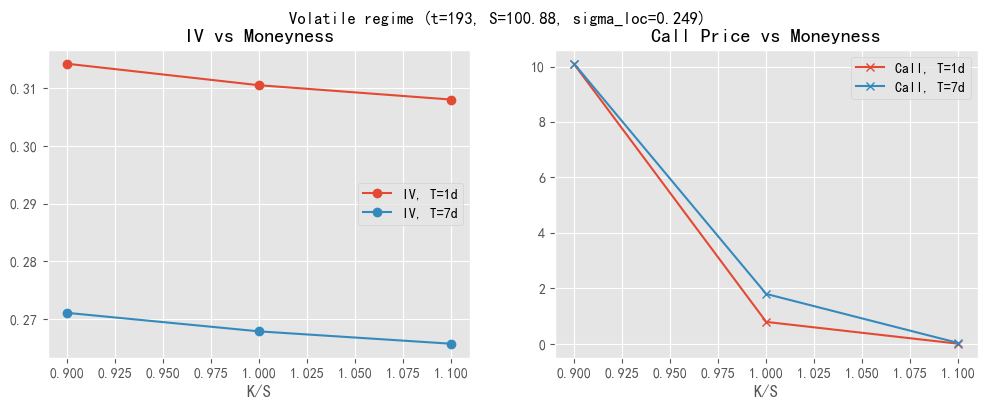

In [9]:
#3.4
import numpy as np
import matplotlib.pyplot as plt

# ==========================
# 需要你自己已有的函数
# ==========================
# 1. 你的 IV surface 函数，示例：
def iv_surface(K, S, tau, sigma_loc):
    m = K / S
    # 示例微笑结构（你可替换为自己的版本）
    a, b = 0.2, -0.1
    smile = 1 + a * (m - 1)**2 + b * (m - 1)
    term = 1 + 0.3 * np.exp(-tau * 50)
    return sigma_loc * smile * term

# 2. Black-Scholes 欧式 call & put（如你已有，可替换）
from scipy.stats import norm
def bs_call(S, K, r, sigma, tau):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    return S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)

def bs_put(S, K, r, sigma, tau):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    return K * np.exp(-r * tau) * norm.cdf(-d2) - S * norm.cdf(-d1)

# ==========================
# 数据准备
# ==========================
# 示例：假设你有 S_path 和 sigma_loc_path
# 请替换为你自己的模拟数据
np.random.seed(0)
T_sim = 200
S_path = 100 * np.exp(0.1 * np.cumsum(0.01*np.random.randn(T_sim)))
sigma_loc_path = 0.15 + 0.1 * np.random.rand(T_sim)

# 选 calm / volatile 时间
calm_idx = np.argmin(sigma_loc_path)
vol_idx  = np.argmax(sigma_loc_path)

# 固定参数
r = 0.0
Ks = [0.9, 1.0, 1.1]
taus = [1/252, 7/252]  # 1d, 7d

# ==========================
# 绘图函数
# ==========================
def plot_iv_and_price(idx, label):
    S = S_path[idx]
    sigma_loc = sigma_loc_path[idx]

    plt.figure(figsize=(12,4))
    plt.suptitle(f"{label} regime (t={idx}, S={S:.2f}, sigma_loc={sigma_loc:.3f})")

    # ----- Plot IV -----
    plt.subplot(1,2,1)
    for tau in taus:
        ivs = [iv_surface(K*S, S, tau, sigma_loc) for K in Ks]
        plt.plot(Ks, ivs, marker="o", label=f"IV, T={tau*252:.0f}d")
    plt.title("IV vs Moneyness")
    plt.xlabel("K/S")
    plt.legend()

    # ----- Plot Option Prices -----
    plt.subplot(1,2,2)
    for tau in taus:
        prices = []
        for K in Ks:
            sigma = iv_surface(K*S, S, tau, sigma_loc)
            prices.append(bs_call(S, K*S, r, sigma, tau))
        plt.plot(Ks, prices, marker="x", label=f"Call, T={tau*252:.0f}d")
    plt.title("Call Price vs Moneyness")
    plt.xlabel("K/S")
    plt.legend()

    plt.show()


# ==========================
# 生成图
# ==========================
plot_iv_and_price(calm_idx, "Calm")
plot_iv_and_price(vol_idx, "Volatile")
